### Primer 4 - Sheet music validator

Sliku primer4_train.png koristiti za obučavanje veštačke neuronske mreže tako da prepoznaje dužinu trajanja note.

Nakon obučavanja, sa slike primer4_test.png odrediti za svaku od ćelija, za koliko odstupa od vrednosti 1. Na primer, prva ćelija odstupa za: 1 - 1/8 + 1/16 + 1/2 + 1/8 = 3/16 Rešenje može biti negativno i dovoljno je da bude iskazano u decimalnom zapisu.

In [38]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD
from keras.utils import np_utils, generic_utils


import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def remove_noise(binary_image):
    ret_val = binary_image
    ret_val = invert(ret_val)
    return ret_val


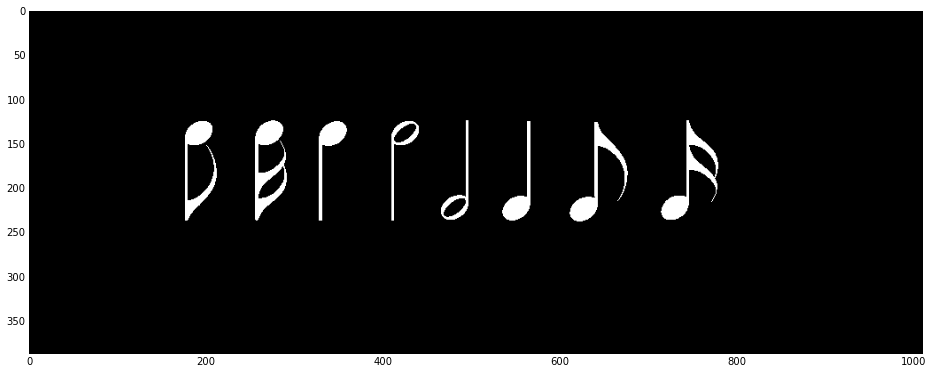

In [39]:
img_train=load_image('primer4_train.png')
display_image(img_train)
img_train_bin=remove_noise(image_bin(image_gray(img_train)))
display_image(img_train_bin)

In [40]:
def rotate_regions(contours,angles,centers,sizes):
    '''Funkcija koja vrši rotiranje regiona oko njihovih centralnih tačaka
    Args:
        contours: skup svih kontura [kontura1, kontura2, ..., konturaN]
        angles:   skup svih uglova nagiba kontura [nagib1, nagib2, ..., nagibN]
        centers:  skup svih centara minimalnih pravougaonika koji su opisani 
                  oko kontura [centar1, centar2, ..., centarN]
        sizes:    skup parova (height,width) koji predstavljaju duzine stranica minimalnog
                  pravougaonika koji je opisan oko konture [(h1,w1), (h2,w2), ...,(hN,wN)]
    Return:
        ret_val: rotirane konture'''
    ret_val = []
    for idx, contour in enumerate(contours):
                
        angle = angles[idx]
        cx,cy = centers[idx]
        height, width = sizes[idx]
        if width<height:
            angle+=90
            
        # Rotiranje svake tačke regiona oko centra rotacije
        alpha = np.pi/2 - abs(np.radians(angle))
        region_points_rotated = np.ndarray((len(contour), 2), dtype=np.int16)
        for i, point in enumerate(contour):
            x = point[0]
            y = point[1]
            
            rx = np.sin(alpha)*(x-cx) - np.cos(alpha)*(y-cy) + cx
            ry = np.cos(alpha)*(x-cx) + np.sin(alpha)*(y-cy) + cy
            
            
            region_points_rotated[i] = [rx,ry]
        ret_val.append(region_points_rotated)
        

    return ret_val

In [52]:
def select_roi(image_orig, image_bin, rotate=False):
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours = []
    contour_angles = []
    contour_centers = []
    contour_sizes = []
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,w,h = cv2.boundingRect(contour)
            
        region_points = []
        for i in range (xt,xt+w):
            for j in range(yt,yt+h):
                dist = cv2.pointPolygonTest(contour,(i,j),False)
                if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                    region_points.append([i,j])
        contour_centers.append(center)
        contour_angles.append(angle)
        contour_sizes.append(size)
        contours.append(region_points)
    
    contours = to_np_array(contours, contour_angles, contour_centers, contour_sizes, rotate)
    max_x_cord = 0
    max_y_cord = 0
                    
    for ind,contour in enumerate(contours):
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])
        
        if( ind == 0):
            max_x_cord = min_x+(max_x-min_x)
            max_y_cord = min_y
        else: 
            
            if(max_x_cord < min_x+(max_x-min_x)):
                 max_x_cord = min_x+(max_x-min_x)
            
            if(max_y_cord < min_y):
                max_y_cord = min_y
                
    
    
    
    
    
    
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])
        
        
        cv2.rectangle(image_orig,(min_x,min_y),(min_x+(max_x-min_x),min_y+(max_y-min_y)),(255,0,0),2)
        
        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
            region[y-min_y,x-min_x] = 255
        
        sort= 0
        if(min_y >=max_y_cord -10):
            sort = max_x_cord
        
            
            
        regions_dict[min_x+sort] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    
    
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][1]-sorted_rectangles[0][3]]
    # Izdvojiti sortirane parametre opisujućih pravougaonika
    # Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += y
        region_distances.append(-y-h)
    region_distances[-1] += sorted_rectangles[-1][1]
    
    return image_orig, sorted_regions[:, 0], region_distances

In [53]:
img_train=load_image('primer4_train.png')
img_train_bin=remove_noise(image_bin(image_gray(img_train)))
selected_regions, shapes, region_distances = select_roi(img_train.copy(), img_train_bin)
display_image(selected_regions)

NameError: global name 'to_np_array' is not defined

In [44]:
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    ann.add(Dense(input_dim=128, output_dim=29,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

ValueError: Input dimension mis-match. (input[0].shape[1] = 29, input[1].shape[1] = 8)
Apply node that caused the error: Elemwise{Sub}[(0, 0)](AdvancedSubtensor1.0, AdvancedSubtensor1.0)
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(1L, 29L), (1L, 8L)]
Inputs strides: [(232L, 8L), (64L, 8L)]
Inputs values: ['not shown', 'not shown']

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

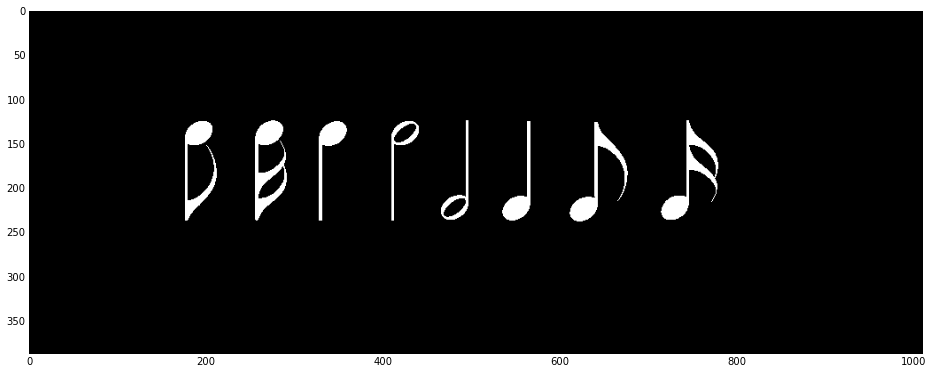

In [45]:
img_train = load_image('primer4_train.png')
img_train_bin = invert(image_bin(image_gray(img_train)))
sel_img_train, shapes, sizes = select_roi(img_train.copy(), img_train_bin)
display_image(img_train_bin)

inputs = prepare_for_ann(shapes)
alphabet = ['osmina','sesnaestina','cetvrtina','polovina','polovina','cetvrtina','sesnaestina','osmina']
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

In [46]:
def display_result(outputs, alphabet):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    
    for idx, output in enumerate(outputs[:,:]):
        elem = alphabet[winner(output)]
    
    result = elem
    for key, value in big_elements.iteritems():
        result += str(value) + " big " + str(key) + ("s\n" if (value > 1 and value != 0) else "\n")
    for key, value in small_elements.iteritems():
        result += str(value) + " small " + str(key) + ("s\n" if (value > 1 and value != 0) else "\n")
    return result
    

IndexError: list index out of range

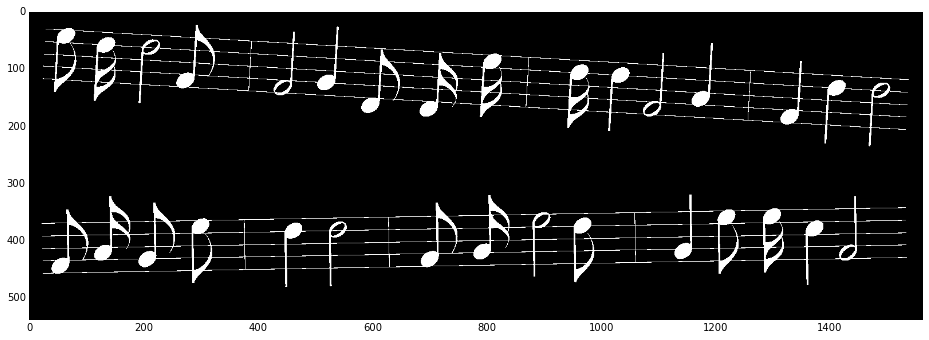

In [49]:
img_test = load_image('primer4_test.png')
img_test_bin = remove_noise(image_bin(image_gray(img_test)))

display_image(img_test_bin)
sel_img_test, shapes, sizes = select_roi(img_test.copy(), img_test_bin)

sizes = np.array(sizes).reshape(len(sizes), 1)


inputs = prepare_for_ann(shapes)
results = ann.predict(np.array(inputs, np.float32))
print display_result(results, alphabet)